In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

In [73]:
def get_data(f, repartition):
    products = pd.read_csv(f, sep=';')
    
    print("nombre de lignes avant de supprimer celles sans rayon : " + str(products.shape[0]))
    # élimine les preoduits sans nom de rayon associé
    products = products[~products['hypSectorDesc'].isnull()]
    print("nombre de lignes après la supression de celles sans rayon : " + str(products.shape[0]))
    
    x = products['product_name'] # récupérer le nom des produits
    y = products['hypDepartmentDesc'] # récupérer le nom des rayons
    
    print("apercu des données : " + x.head())
    print("apercu des labels : " + y.head())

    print("nombre de données avant la supression des doublons : " + str(len(x)))

    x, y = delete_duplicate(x, y)

    print("nombre de données après la supression de doublons : " + str(len(x)))

    # Convertit les mots en numéro pour analyse par nlp
    x = auto_encoder_x(x)
    
    # Associe des numéros pour chaque rayon et transforme les numéros en un vecteur binaire
    # ex : 28 rayons, le rayon ayant pour num 0 aura comme vecteur : (1, 0, 0, 0 , ..., 0) le vecteur ayant 28 places car
    # il y a 28 valeurs différentes de y
    y = np.array(auto_encoder_y(y))

    # Sépare en données d'entrainement et de test
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=repartition)
    

    return x_tr, x_te, y_tr, y_te, size_y

In [74]:
def auto_encoder_x(products_name):
    
    # 20 000 mots maximum à garder et remplace les mots inconnus avec le token out-of-value
    tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

    # Crée le dictionnaire
    tokenizer.fit_on_texts(products_name)

    # Les mots sont remplacées par leurs numéros associés
    sequences = tokenizer.texts_to_sequences(products_name)

    # Ajoute du padding pour que chaque ligne ait la même taille
    padded = pad_sequences(sequences, padding='post', truncating='pre')

    return padded

In [75]:
def number_to_binary(number, size):
    return [0 if i != number else 1 for i in range(size)]

def auto_encoder_y(label_name):
    # Associe des numéros pour chaque rayon et transforme les numéros en un vecteur binaire
    # ex : 28 rayons, le rayon ayant pour num 0 aura comme vecteur : (1, 0, 0, 0 , ..., 0) le vecteur ayant 28 places car
    # il y a 28 valeurs différentes de y
    possibilities = label_name.unique()
    size = possibilities.shape[0]

    result = []
    words = {possibilities[i]: i for i in range(size)}

    for l in label_name:
        nb = words[l]
        val = number_to_binary(nb, size)
        result.append(val)

    return result

In [76]:
def delete_duplicate(x, y):
    df = pd.concat([x, y], axis=1)

    df.drop_duplicates(subset="product_name", keep=False, inplace=True)

    return df["product_name"], df["hypDepartmentDesc"]

In [77]:
# Structure du réseau de neurones
def neural_network(size_y, batch_size):
    model = keras.Sequential([
        Embedding(15000, 128, input_length=25),
        LSTM(64, return_sequences=True),
        LSTM(32, return_sequences=True),
        LSTM(16),
        Dense(64, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dense(32, kernel_regularizer=keras.regularizers.l2(0.01)),
        Dense(size_y, activation=keras.activations.softmax)
    ])

    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy,
                  metrics=keras.metrics.categorical_accuracy)

    logs = model.fit(x_train, y_train, batch_size=batch_size, epochs=150, validation_data=(x_test, y_test)
                     , callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), verbose=2)

    return logs

In [78]:
# Afficher les courbes de loss et accuracy à l'aide de matplotlib
def plot_log(all_logs):
    for logs in all_logs:
        losses = logs.history['loss']
        name = logs.history['name'] + " - training"
        plt.plot(list(range(len(losses))), losses, label=name)
        losses = logs.history['val_loss']
        name = logs.history['name'] + " - testing"
        plt.plot(list(range(len(losses))), losses, label=name)
    plt.xlabel("number of epochs")
    plt.ylabel("error")
    plt.title("error on training/testing")
    plt.legend()
    plt.show()

    for logs in all_logs:
        metric = logs.history['categorical_accuracy']
        name = logs.history['name'] + " - training"
        plt.plot(list(range(len(metric))), metric, label=name)
        metric = logs.history['val_categorical_accuracy']
        name = logs.history['name'] + " - testing"
        plt.plot(list(range(len(metric))), metric, label=name)
    plt.xlabel("number of epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("prediction accuracy on training/testing")
    plt.show()

nombre de lignes avant de supprimer celles sans rayon : 36160
nombre de lignes après la supression de celles sans rayon : 36108
0    apercu des données : Kinder Calendrier de l'Av...
1    apercu des données : Lindt Calendrier de l'Ave...
2    apercu des données : Célébrations Calendrier d...
3    apercu des données : Kinder Calendrier De L'Av...
4    apercu des données : M&M'S Calendrier de l'Ave...
Name: product_name, dtype: object
0    apercu des labels : EPICERIE
1    apercu des labels : EPICERIE
2    apercu des labels : EPICERIE
3    apercu des labels : EPICERIE
4    apercu des labels : EPICERIE
Name: hypDepartmentDesc, dtype: object
nombre de données avant la supression des doublons : 36108
nombre de données après la supression de doublons : 12951
nombre de catégories : 25
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 128)           19

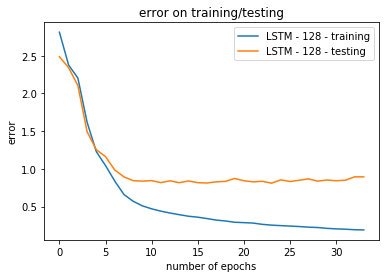

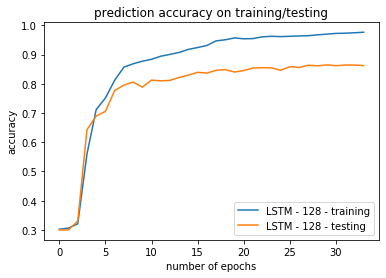

In [80]:
if __name__ == "__main__":
    name_file = "produits_carrefour_nomenclatures.csv"
    batch_size = 128

    all_logs = []

    x_train, x_test, y_train, y_test, size_y = get_data(name_file, 0.2)
    
    print("nombre de catégories : " + str(size_y))

    logs = neural_network(size_y, batch_size)

    logs.history['name'] = "LSTM - " + str(batch_size)

    all_logs.append(logs)

    plot_log(all_logs)